(observed episode) trajectory of states and actions (time = T is terminal):
$$\tau = \{s_0, a_0, s_1,\dots\,s_{T-1}, a_{T-1}, s_T\}$$
_notice there is no action $a_T$ from terminal state $s_T$._

(observed episode) rewards from trajectory"
$$ r_\tau =  \{r_0, r_1,\dots,r_T\}$$
finite-horizon undiscounted return:
$$ R(\tau) = \sum_{t = 0}^T r_t$$
finite-horizon discounted return:
$$ R(\tau) = \sum_{t = 0}^T \gamma^t r_t$$
Policy $\pi$ decides which actions to take from state $s$:
$$\pi = \pi(a_t|s_t) \ (\forall t \in [0,1,\dots, T - 1])$$
Stochasticity of environment shows itself in probabilistic response to actions:
$$P(s_{t+1}|s_t,a_t)$$
Probability of a trajectory under policy $\pi$:
$$P(\tau|\pi) = \rho_0(s_0) \cdot \pi(a_0|s_0) \cdot P(s_1|s_0,a_0)\cdot\pi(a_1|s_1)\cdot P(s_2|s_1,a_1)\cdot \dots$$
$$ = \rho_0(s_0)\cdot \prod_{t=0}^{T-1} \pi(a_t|s_t) \cdot P(s_{t+1}|s_t,a_t)$$
_where $\rho_0(s_0)$ is a probability of starting in state $s_0$. Its controlled by environment._

_we employ Markov property here to get rid of the history:_
$$P(s_{t+2}|s_t,s_{t+1},a_t,a_{t+1}) = P(s_{t+2}|s_{t+1}, a_{t+1})$$

We can measure performance $J(\pi)$ of a given policy $\pi$ by examining many trajectories $\tau \in D$, their cumulative rewards $R(\tau)$. This can be done by computing expected rewards:
$$\boxed{J(\pi) = \sum_{\tau \in D} P(\tau|\pi) \cdot R(\tau) = \underset{\tau \sim \pi}{\mathbb{E}}[R(\tau)]}$$

In most cases policy should be approximated by parametric representation 
$$\pi_{\vec{\theta}}=\pi(a|s,\vec{\theta})$$
, where $\vec{\theta}$ is a vector of parameters. _I will omit vector sign in the future._

Approximation can be learned by performing gradient de-/ascent:
$$\theta_{t+1} = \theta_t + \alpha \nabla_{\theta} J(\pi_{\theta_t})$$
where $t$ are 'time steps' at which wight update is conducted.

in order to determine 
$$\nabla_{\theta} J(\pi_{\theta}) =  \sum_{\tau \in D} \nabla_{\theta} \bigg[P(\tau|\pi_{\theta}) \cdot R(\tau) \bigg] = \sum_{\tau \in D} \nabla_{\theta} \bigg[\rho_0(s_0)\cdot \prod_{t=0}^{T-1} \pi_\theta(a_t|s_t) \cdot P(s_{t+1}|s_t,a_t) \cdot R(\tau) \bigg]$$ 
we can calculate:
$$\nabla_{\theta}P(\tau|\theta) = P(\tau|\theta)\cdot\nabla_{\theta} \ log P(\tau|\theta)$$
and
$$\nabla_{\theta} \ log P(\tau|\theta) = \sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t)$$
After few mathematical manipulations:
$$\boxed{\nabla_{\theta} J(\pi_{\theta}) =  \underset{\tau \sim \pi}{\mathbb{E}}\bigg[ \sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) R(\tau) \bigg]}$$
where expectation is taken over probability of a trajectory, _but given many sample episodes it can be estimated by a mean_:
$$\underset{\tau \sim \pi}{\mathbb{E}}[\ \cdot \ ] \longrightarrow \frac{1}{|D|} \sum_{\tau \in D}[\ \cdot \ ]$$

$$\boxed{\nabla_{\theta} J(\pi_{\theta}) =  \frac{1}{|D|} \sum_{\tau \in D}R(\tau)\cdot\sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) }$$

As i understand it, policy can converge under stochastic gradient descent, with $\frac{1}{|D|}$ being absorbed into step size.

So objective function can be optimized into direction of:
$$\nabla_{\theta} J^\prime(\pi_{\theta}) = R(\tau)\cdot\sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) =\nabla_{\theta} \bigg[ R(\tau)\cdot\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \bigg]$$
at the end of each episode.

Thus objective function can be defined as
$$L(\tau) =  R(\tau)\cdot\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) $$ 
which can be maximized using other variation of gradient as-/descent.

Maybe initial episodes are too short so OpenAi's 'spinningup' offers to __batch many episodes start-to-back__ before doing grad update

In [30]:
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch, gym, numpy as np
from data_processing.neural_networks.DEEP_RL_Deep_Reinfocement_Learning.DEEP_RL_funcs import Simple_PG
env_CP = gym.make('CartPole-v1')
num_obs = env_CP.observation_space.shape[0]
num_acts = env_CP.action_space.n

sim_PG = Simple_PG(inp_size=num_obs, hidden_sizes=[32], out_size=num_acts)

optimizer = Adam(sim_PG.mlp.parameters(), lr=1e-2)
progress = []

In [ ]:
batch_size = 5000

for _ in range(50):
    obs = env_CP.reset()[0]
    batch_rewards   = []
    batch_states    = [obs]
    batch_actions   = []
    batch_times     = []

    t = 0
    reward_ep = 0
    while True:
        action = sim_PG.get_action(obs)
        batch_actions.append(action)
        obs, rew, episode_finished = env_CP.step(action)[:3]
        reward_ep += rew
        t += 1
        if episode_finished or t >= 300:
            sim_PG.env_iters += 1
            batch_times.append(t)
            batch_rewards += [reward_ep]*t
            obs = env_CP.reset()[0]
            reward_ep = 0
            t = 0
            if len(batch_actions) >= batch_size: 
                break

        batch_states.append(obs.copy())


    optimizer.zero_grad()
    log_probs = sim_PG.log_prob(batch_states, batch_actions)
    loss = -1*(log_probs*torch.as_tensor(batch_rewards)).mean()

    loss.backward()
    optimizer.step()
    avg_steps = torch.as_tensor(batch_times).to(float).mean().item()
    progress.append(avg_steps)
    #print(f'{avg_steps:0.2f}')

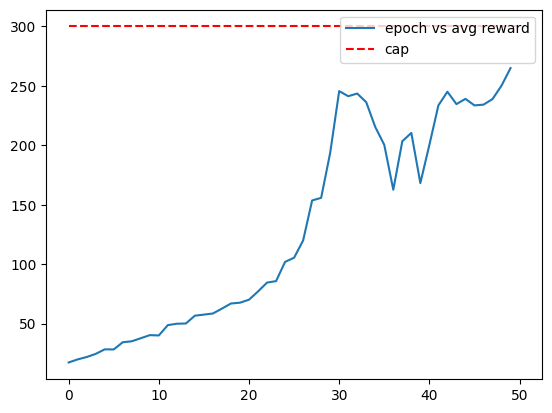

In [44]:
plt.plot(progress, label='epoch vs avg reward')    ;
plt.hlines(300, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()

In [32]:
from tqdm import tqdm

n=1000

env = gym.make("CartPole-v1", render_mode="human")

observation, info = env.reset(seed=82)

for _ in tqdm(range(n)):
    action = sim_PG.get_action(observation)
    observation,reward, terminated, truncated, info = env.step(action)
    #print("info : ",info);
    
    if terminated or truncated:
        observation, info = env.reset()
        break
        
env.close()

 30%|██▉       | 296/1000 [00:06<00:14, 48.54it/s]


One can change weighting of log-probabilities $\pi_\theta(a_t|s_t)$ to take account only future reward from time $t$:
$$L(\tau) = \sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot \sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1})$$
Sutton and Bartol would write these rewards as $G_{t^\prime:T}$

Of course it can be done only in the end of episode (via reversed cum-sum).

In [54]:
sim_PG2 = Simple_PG(inp_size=num_obs, hidden_sizes=[32], out_size=num_acts)

optimizer = Adam(sim_PG2.mlp.parameters(), lr=1e-2)
progress = []

In [ ]:
batch_size = 5000

for _ in range(50):
    obs = env_CP.reset()[0]
    batch_rewards   = []
    batch_states    = [obs]
    batch_actions   = []
    batch_times     = []

    t = 0
    ep_rewards = []
    while True:
        action = sim_PG2.get_action(obs)
        batch_actions.append(action)
        obs, rew, episode_finished = env_CP.step(action)[:3]
        ep_rewards.append(rew)
        t += 1
        if episode_finished or t >= 300:
            sim_PG2.env_iters += 1
            batch_times.append(t)
            batch_rewards += list(np.flip(np.cumsum(np.flip(ep_rewards))))
            obs = env_CP.reset()[0]
            ep_rewards = []
            t = 0
            if len(batch_actions) >= batch_size: 
                break

        batch_states.append(obs.copy())


    optimizer.zero_grad()
    log_probs = sim_PG2.log_prob(batch_states, batch_actions)
    loss = -1*(log_probs*torch.as_tensor(batch_rewards)).mean()

    loss.backward()
    optimizer.step()
    avg_steps = torch.as_tensor(batch_times).to(float).mean().item()
    progress.append(avg_steps)
    print(f'{avg_steps:0.2f}')

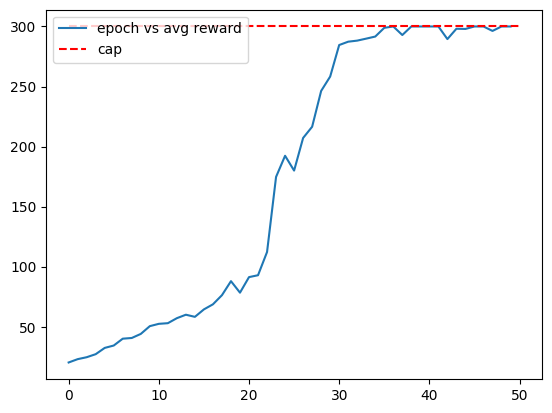

In [56]:
plt.plot(progress, label='epoch vs avg reward')    ;
plt.hlines(300, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()

Additional modification is to include a _baseline function_ $b(s_t)$, so:
$$L(\tau) = \sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot \bigg(\sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)\bigg)$$
This can be a state value function, which should learned parallel to policy.

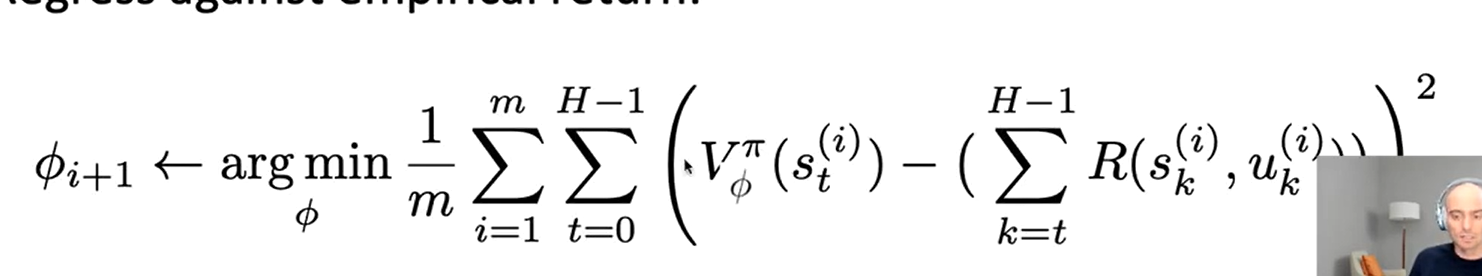

In [106]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

class env_info():
    def __init__(self, env_name, *args) -> None:
        self.env = gym.make(env_name, *args)
        self.batch_states       = []
        self.batch_actions      = []
        self.batch_rewards      = []
        self.episode_rewards    = []
        self.env_iters = 0

    def reset(self):
        state = self.env.reset()[0]
        self.batch_states.append(state)
        return state
    
    def step(self, action):
        self.batch_actions.append(action)
        state, reward, done = self.env.step(action)[:3]
        self.batch_rewards.append(reward)
        if not done:
            self.batch_states.append(state)
        return state, reward, done
    
    def add_ep_rewards_2_go(self):
        self.batch_rewards += list(np.flip(np.cumsum(np.flip(self.episode_rewards))))
    
class MLP():
    def __init__(self, inp_size, out_size, hidden_sizes, activation = nn.Tanh,activation_out = nn.Identity, lr = 1e-2) -> None:
        self.act            = activation
        self.act_out        = activation_out
        self.layer_sizes    = [inp_size] + hidden_sizes + [out_size]
        self.mlp            = self.seq()
        self.optimizer      = Adam(self.mlp.parameters(), lr=lr)

    def seq(self):
        layers      = []
        for i,j in zip(self.layer_sizes[:-1],self.layer_sizes[1:]):
            layers  += [nn.Linear(i,j, dtype=float), self.act()]
        layers[-1]  = self.act_out()
        return nn.Sequential(*layers)
    
class policy(MLP):
    def __init__(self, inp_size, out_size, hidden_sizes, activation=nn.Tanh, activation_out=nn.Identity, lr=0.01) -> None:
        super().__init__(inp_size, out_size, hidden_sizes, activation, activation_out, lr)

    def get_policy(self,observation):
        return Categorical(logits=self.mlp(torch.as_tensor(observation)))
    
    def get_action(self, observation):
        return self.get_policy(observation).sample().item()
    

class value(MLP):
    def __init__(self, inp_size, out_size, hidden_sizes, activation=nn.Tanh, activation_out=nn.Identity, lr=0.01) -> None:
        super().__init__(inp_size, out_size, hidden_sizes, activation, activation_out, lr)

    def get_value(self, observation):
        return self.mlp(torch.as_tensor(observation))
    
    def train(self, observations, rewards, n_iters = 50):
        loss = nn.MSELoss()
        for _ in range(n_iters):
            x = self.get_value(observations)
            y = torch.as_tensor(rewards)
            self.optimizer.zero_grad()
            output = loss(x,y)
            output.backward()
            self.optimizer.step() 
    

## Test value function fit

In [179]:
def target_fn(x,y):
  return (torch.sin(x) + torch.cos(y))

def target_fn_noisy(x,yy):
  r = target_fn(x,yy)
  return r + 0.05 * torch.randn(size=r.shape)

x,y = xyT = 2.0 * torch.pi *  torch.rand(size = (3,2), dtype = float).T
target_fn(x,y).shape

torch.Size([3])

In [185]:
val_fn = value(2,1,[32])
for i in range(10):
    x,y = xyT = 2.0 * torch.pi *  torch.rand(size = (200,2), dtype = float).T
    target = target_fn_noisy(x,y)
    #print(target.shape)
    val_fn.train(xyT.T, target.reshape(-1,1),n_iters= 100)

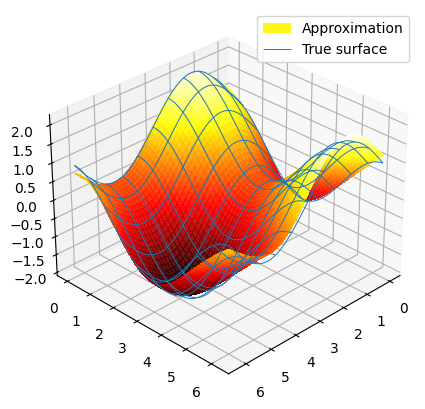

In [186]:
res = 100
x = torch.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
y = torch.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    z[i,j] =  val_fn.get_value(torch.Tensor([x[i],y[j]]).to(float))[0].detach().item()
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d',computed_zorder=False)
X, Y = torch.meshgrid(x, y)
surf = ax.plot_surface(X.numpy(), Y.numpy(), z, cmap=plt.get_cmap('hot'), linewidth=1.5, antialiased=False, alpha = 0.9, label='Approximation')
Z = target_fn(X,Y).reshape(res,res)
ax.plot_wireframe(X.numpy(), Y.numpy(), Z.numpy(), rstride=10, cstride=10, linewidth = 0.7, label='True surface')#, zorder = 100)
ax.view_init(elev=30., azim=45)
plt.legend()
plt.show()